## Import relevant packages ##

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table, vstack
import pandas as pd
import lmfit
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

In [271]:
# define colors to be used across presentation:
lime = '#e4ffba'
lemon = '#fef6c7'
bora = '#b186ce'
sky = '#b2eaf0'
strawberry = '#ff9cff'
coral = '#feb5a4'

In [354]:
# Set Matplotlib style parameters for dark background
rcParams['figure.facecolor'] = 'black'  # Dark background color
rcParams['axes.facecolor'] = 'black'
rcParams['axes.edgecolor'] = sky
rcParams['axes.labelcolor'] = sky
rcParams['xtick.color'] = sky
rcParams['ytick.color'] = sky
rcParams['text.color'] = sky
rcParams['axes.titlecolor'] = sky

## Define plotting functions:

In [371]:
def plot_data(ax, sm, data, mode, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':('s', coral), 'ALMA':('o', bora), 'e-MERLIN':('d', lime)}
    epoch_marker_dict = {'epoch1':(sky, '~1360 days'), 'epoch2':(lemon, '~1700 days')}

    epoch1_count = 0
    epoch2_count = 0

    for row in data:
        if mode == 'lc':
            x = row['time']
            # set marker color based on frequency
            freq = row['freq']
            colorval = sm.to_rgba(freq)
        if mode == 'sed':
            x = row['freq']
            # colorval = sm.to_rgba(time)

        telescope = row['telescope']
        marker = telescope_marker_dict[telescope][0]
        color = telescope_marker_dict[telescope][1]

        # set marker color based on time
        time = row['time']
        if time < 1600.0:
            epoch1_count += 1
            colorval = epoch_marker_dict['epoch1'][0]
            if epoch1_count == 1:
                label = epoch_marker_dict['epoch1'][1]
            else:
                label = None
        elif time > 1600.0:
            epoch2_count += 1
            colorval = epoch_marker_dict['epoch2'][0]
            if epoch2_count == 1:
                label = epoch_marker_dict['epoch2'][1]
            else:
                label = None
        
        if scaled:
            flux = row['scaled_flux']
            err = row['scaled_flux_err']
        else:
            flux = row['flux']
            err = row['flux_err']

        ax.errorbar(x, flux, yerr=err, marker=marker, c=colorval)
        # ax.legend()
    return

def make_plot(data, mode, title='', xlabel='', ylabel='', freq_vals=np.linspace(0, 300, 300), cbar=True, scaled=False, models=None, params=None, model_names=None, plot_models=False, modelcolors=None, vline=None, vlinecolors=None, xlim=None, ylim=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    if cbar:
        # get the scalar map, plot the data using the plot_data function
        sm = cmap_setup(mode)
        plot_data(ax, sm, data, mode, scaled=scaled)

        # set up colorbar
        if mode == 'lc':
            fig.colorbar(sm, fraction=0.046, label=r'$\nu$ [GHz]')
        elif mode == 'sed':
            fig.colorbar(sm, fraction=0.046, label='time [Days]')
    else:
        sm = None
        plot_data(ax, sm, data, mode, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    # set x limits
    if xlim != None:
        ax.set_xlim(xlim)

    #Label axes, set axis limits etc.
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if scaled:
        ax.set_ylabel('Scaled Flux Density (mJy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel(ylabel)

    if mode == 'lc':
        x = data['time']
    elif mode == 'sed':
        x = data['freq']

    if models!=None:
        for i, (model,param,model_name,color) in enumerate(zip(models,params,model_names,modelcolors)):
            plot_model(model, param, x, ax, model_name, color, freq_vals=freq_vals, ylim=ylim)

    if vline != None:
        for i, (line, linecolor) in enumerate(zip(vline, vlinecolors)):
            ax.axvline(x=line, color=linecolor, linestyle='--')

cmap = LinearSegmentedColormap.from_list('custom_cmap', [coral, bora], N=256)
def cmap_setup(mode, cmap=cmap, min_freq=0, max_freq=300, min_time=1360, max_time=1370):
    '''
    color markers by frequency/time
    '''
    if mode == 'lc':
        freq_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    elif mode == 'sed':
        time_cmap = plt.cm.get_cmap(cmap)
        
        cNorm  = colors.Normalize(vmin=min_time, vmax=max_time)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        sm = scalarMap
        sm._A = []
    
    return sm   


# define model plotting function to be incorporated into makeplot()
def plot_model(model, params, x, ax, label, modelcolor, freq_vals=np.linspace(0, 300, 300), ylim=None):

    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]

    fit = model(freq_vals, *params)
    ax.plot(freq_vals, fit, label=label, color=modelcolor)
    if ylim != None:
        ax.set_ylim(ylim)
    ax.legend()
    return

## Input Flux Density Values

From my project:

In [274]:
# create another data table with the data from my project:
# observation type:
# 6211, 6355, 6488, 5859, 6035, 7037, 6759, 7214
observation = np.array(['KuD', 'XD', 'CD', 'KD', 'KaD', 'KA', 'XA', 'KaA'])

# days since explosion
phase = np.array([1363.2, 1365.1, 1368.1, 1369.2, 1369.1, 1688.1, 1689.9, 1702.2])

# frequency of each observation (GHz)
freq = np.array([15.1, 10.0, 6.0, 22.0, 33.0, 22.0, 10.0, 33.0])

# fluxes at each time/frequency (mJy)
# 0 just means I have yet to input that value
flux = np.array([6.476, 7.023, 7.0, 7.055, 2.70, 3.485, 5.882, 3.072])

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.array([0.818, 0.944, 0.5, 0.673, 0.20, 0.468, 0.577, 0.177])

# telescope observation was made with
telescope = np.array(['VLA']*8)

table = np.column_stack((observation, phase, freq, flux, flux_err, telescope))
data = Table(table, names=['observation', 'time', 'freq', 'flux', 'flux_err', 'telescope'])
data['time'] = data['time'].astype(float)
data['freq'] = data['freq'].astype(float)
data['flux'] = data['flux'].astype(float)
data['flux_err'] = data['flux_err'].astype(float)

From previous ALMA data:

In [275]:
# observation, just to match the other table:
observation = np.zeros(16)

# days since explosion
phase = np.array([4.1, 7.1, 17.1, 21.0, 198.6, 213.5, 306.2, 1024.4, 1364.4, 4.1, 6.2, 17.1, 198.6, 1364.4, 1217, 1217])

# frequency of each observation (GHz)
freq = np.array([100.0, 100.0, 100.0, 93.5, 100.0, 92.1, 103.0, 92.1, 100.0, 250.0, 250.0, 250.0, 250.0, 250.0, 6.5, 6.3])

# fluxes at each time/frequency (mJy)
flux = np.array([4.25, 7.42, 9.05, 7.41, 0.336, 0.322, 0.264, 1.128, 0.955, 4.21, 4.32, 2.49, 0.120, 0.286, 9.1, 8.7])

# 1 sigma flux errors at each time/frequency (mJy)
flux_err = np.array([0.22, 0.38, 0.46, 0.99, 0.026, 0.036, 0.044, 0.069, 0.093, 0.43, 0.44, 0.28, 0.022, 0.067, 0.9, 1.3])

# telescope observation was made with
alma = np.array(['ALMA']*14)
vla = np.array(['VLA'])
emerlin = np.array(['e-MERLIN'])
telescope = np.concatenate((alma, vla, emerlin))

table = np.column_stack((observation, phase, freq, flux, flux_err, telescope))
data_ALMA = Table(table, names=['observation','time', 'freq', 'flux', 'flux_err', 'telescope'])
data_ALMA['time'] = data_ALMA['time'].astype(float)
data_ALMA['freq'] = data_ALMA['freq'].astype(float)
data_ALMA['flux'] = data_ALMA['flux'].astype(float)
data_ALMA['flux_err'] = data_ALMA['flux_err'].astype(float)

In [276]:
# concatenate the two tables:
all_data = vstack([data, data_ALMA])
all_data

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.1,6.476,0.818,VLA
XD,1365.1,10.0,7.023,0.944,VLA
CD,1368.1,6.0,7.0,0.5,VLA
KD,1369.2,22.0,7.055,0.673,VLA
KaD,1369.1,33.0,2.7,0.2,VLA
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA
0.0,4.1,100.0,4.25,0.22,ALMA


## Define the relations that will be used for fitting:

SSA dominant case:
$$\tau_{\nu}^{\text{SSA}} = K_2\nu^{-(p+4)/2}$$
$$F_{\nu} = K_1\nu^{5/2}(1-e^{-\tau_{\nu}^{\text{SSA}}})$$

In [277]:
def F_SSA(freq, K1, K2, p):
    """
    Calculate the flux density using Synchotron Self Absorption (SSA) model.

    Parameters:
    freq (float or numpy.ndarray): Frequency values.
    K1 (float): Scaling factor.
    K2 (float): Scaling factor for the optical depth.
    p (float): Power-law index.

    Returns:
    F (numpy.ndarray): Flux density values.
    """
    #scale the freqs by 10
    tau = K2 * (freq/10)**(-(p + 4) / 2)
    F = K1 * (freq/10)**(5/2) * (1 - np.exp(-tau))
    return F

## Fitting to the SSA model

Find the best fit to the data using curve_fit. These will be used as the priors for the MCMC analysis.

In [278]:
def calc_params(data, model, initial_guess, bounds):
    # define variables from data
    freq = data['freq']
    flux = data['flux']
    flux_err = data['flux_err']

    params, covariance = curve_fit(model, freq, flux, p0=initial_guess, bounds=bounds, sigma=flux_err, absolute_sigma=True)

    K1_fit, K2_fit, p_fit = params
    K1_err, K2_err, p_err = np.sqrt(np.diag(covariance))

    # Create a dictionary to store the results
    results = {
        'K1': (K1_fit, K1_err),
        'K2': (K2_fit, K2_err),
        'p': (p_fit, p_err)
    }

    return results

In [279]:
# take the subset of the data at ~1360 days:
data_1 = all_data[((all_data['time'] < 1370.0) & (all_data['time'] > 1360.0) & (all_data['observation'] != 'CD'))]
initial_guess = [100, 0.1, 3.0]
bounds=((0,0,1.4),(np.inf, np.inf,4.0))
results = calc_params(data_1, F_SSA, initial_guess, bounds)
results

{'K1': (10.134306516247333, 3.17902613799178),
 'K2': (1.2077017685191538, 0.47031987665467323),
 'p': (3.2996608231054174, 0.14601258650973176)}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


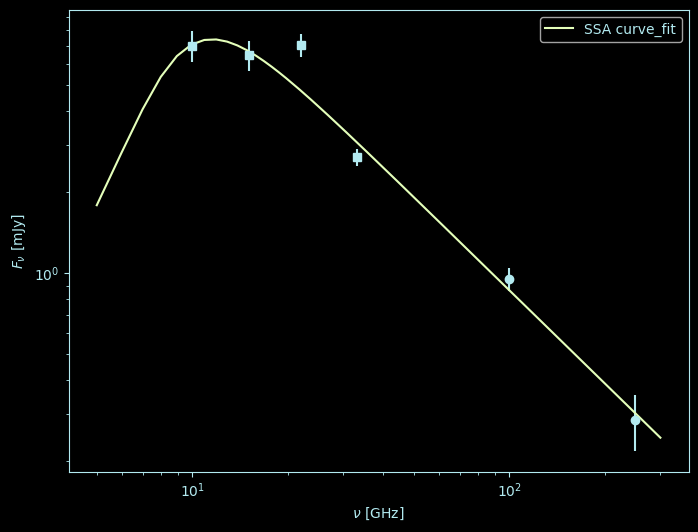

In [360]:
K1 = results['K1'][0]
K2 = results['K2'][0]
p = results['p'][0]
make_plot(data_1, 'sed', xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu}$ [mJy]', freq_vals=np.linspace(5, 300, 300), models=[F_SSA], params=[[K1, K2, p]], model_names = ['SSA curve_fit'], cbar=False, modelcolors=[lime])

Define a prior that imposes the following conditions on our fit. We will input the paramters into the prior as a tuple.
- $K_1 = 10.13 \pm 3.18$
- $K_2 = 1.21 \pm 0.47$
- $p = 3.30 \pm 0.15$

In [281]:
# uniform prior:
def lnprior(theta):
    K1, K2, p = theta
    return 0.0

We will now write a likelihood function that takes the SED parameters inside the tuple theta, along with the observed data.

In [282]:
# F is the flux densities from the data
# F_err are the rms values from the data
def lnlike(theta, nu, F, F_err):
    K1, K2, p = theta

    model = F_SSA(nu, K1, K2, p)
    inv_sigma2 = 1.0/F_err**2

    return -0.5*(np.sum((F-model)**2*inv_sigma2 - np.log(inv_sigma2)))

Now write a function to calculate the marginal probability using the lnlike() and lnprior() functions you calculated above

In [283]:
def lnprob(theta, nu, F, F_err):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, nu, F, F_err)

Get starting positions of walkers for each parameter

In [284]:
K1 = results['K1'][0]
K2 = results['K2'][0]
p = results['p'][0]

def get_starting_pos(nwalkers, values, ndim=3):
    
    pos = [np.asarray(values) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

Write a function to load the data, take the starting positions, and run the mcmc ensemble sampler:

In [285]:
def run_mcmc(data, values, niters=1000, nthreads=1, nwalkers=200, ndim=3):
    nu = data['freq']
    F = data['flux']
    F_err = data['flux_err']
    
    pos = get_starting_pos(nwalkers, values, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, F, F_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler

Actually save the sampler and the chain, to inspect how long the burn-in phase lasts:

In [286]:
sampler = run_mcmc(data_1, [K1, K2, p], niters=2000, nwalkers=400)
chain = sampler.chain

Computation time: 124.214108 s


Assess where the burn in phase occurs:

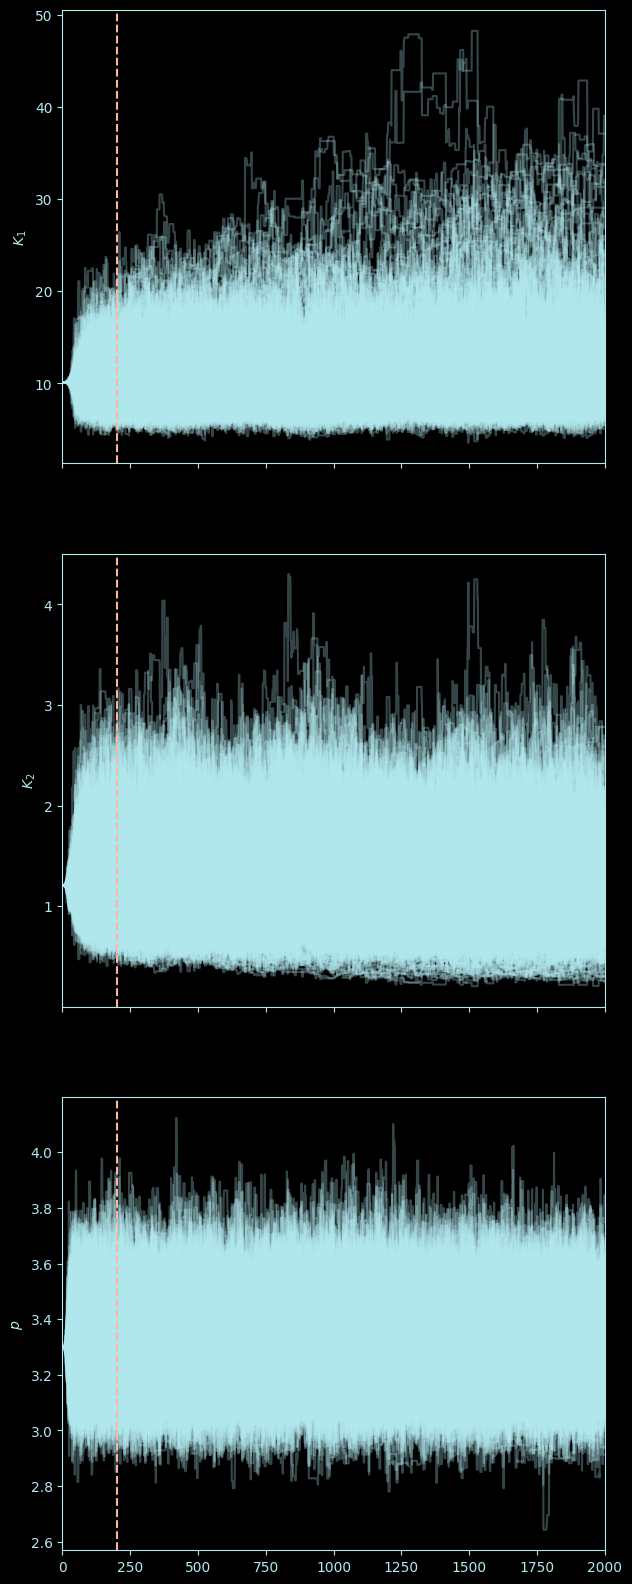

In [365]:
def make_chain_plot(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 20)
    
    param_names = ['$K_1$', '$K_2$','$p$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        #plot the chain for the given parameter
        ax.plot(chain[:,:,i].T, linestyle='-', color=sky, alpha=0.3)
        
        
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        
        
        ax.axvline(chain_cut,c=coral,linestyle='--')

chain_cut = 200

make_chain_plot(chain, chain_cut)

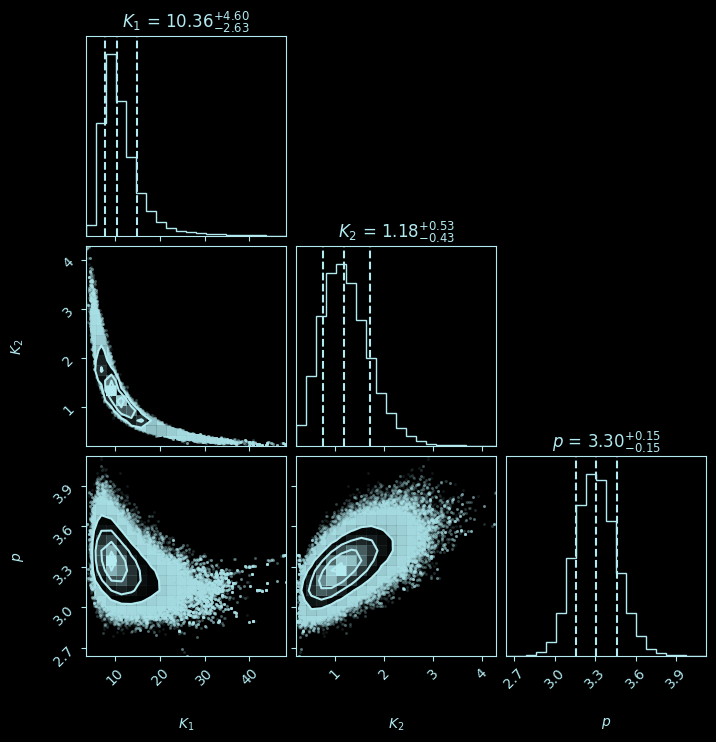

In [288]:
def make_corner_plot(good_chain, savefile='corner.png'):
    param_names = ['$K_1$', '$K_2$','$p$']
    ndim = good_chain.shape[2]

    # Create the corner plot
    fig = corner.corner(good_chain.reshape((-1, ndim)), labels=param_names, quantiles=[0.16, 0.5, 0.84], show_titles=True, facecolor='black')
    
    # Save the plot
    #plt.savefig(savefile, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

good_chain = chain[:, chain_cut:, :]
make_corner_plot(good_chain)

The function below will then extract the median and uncertainty (1 standard deviation) from the chain.

In [289]:
def get_best_params(chain):
    ndim = chain.shape[2] # 3 in this case
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    # ^^ takes every value in the zip() and returns v[1] (actual value), v[2]-v[1] (median?), v[1]-v[0] (1 sigma uncertainty?)

    param_names = ['$K_1$', '$K_2$','$p$']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
 
best_params = get_best_params(good_chain)
best_params

{'$K_1$': (10.360667563251491, 4.603516079343903, 2.6332074590260195),
 '$K_2$': (1.1844642741578923, 0.5306015356484748, 0.4311471601182564),
 '$p$': (3.3043368667970934, 0.1540220624142159, 0.1461669462304096)}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


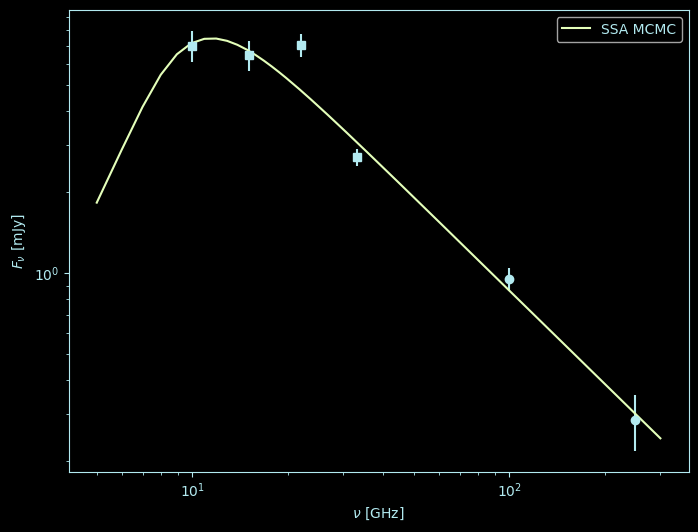

In [367]:
K1 = best_params['$K_1$'][0]
K2 = best_params['$K_2$'][0]
p = best_params['$p$'][0]
make_plot(data_1, 'sed', xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu}$ [mJy]', freq_vals=np.linspace(5, 300, 300), models=[F_SSA], params=[[K1, K2, p]], model_names = ['SSA MCMC'], cbar=False, modelcolors=[lime])

Determine the peak Flux density from this fit, and the frequency at which it occurs:

In [291]:
# define parameters to load into F_SSA
K1 = best_params['$K_1$'][0]
K2 = best_params['$K_2$'][0]
p = best_params['$p$'][0]

# define arrays of x and y values:
freq_vals=np.linspace(5, 300, 300)
F = F_SSA(freq_vals, K1, K2, p)

# concatenate the two arrays into an astropy table:
table = np.column_stack((freq_vals, F))
determine_max = Table(table, names=['freq', 'flux'])

# write the loop to determine the max
max = determine_max['flux'][0]
max_freq = determine_max['freq'][0]

for i in range(len(determine_max)):
    if determine_max['flux'][i] > max:
        max = determine_max['flux'][i]
        max_freq = determine_max['freq'][i]

print(max)
print(max_freq)

7.458994692382134
11.906354515050168


Now write a function, calc_chi2(), that will calculate the $\chi^2$ for the fit. We will use this later to compare different lightcurve models

In [292]:
def calc_chi2(best_params, param_names, model, data):
    args = []
    for param in param_names:
        val = best_params[param][0]
        args.append(val)

    best_fit = model(data['freq'], *args)
    
    chi2 = np.sum((best_fit-data['flux'])**2/data['flux_err']**2)
    
    return chi2

param_names = ['$K_1$', '$K_2$','$p$']

chi2_best = calc_chi2(best_params, param_names, F_SSA, data_1)
print(chi2_best)

16.040558135809885


In [302]:
# calculate reduced chi2:
npts = 6
nparams = 3
dof = npts-nparams
reduced_chi2 = chi2_best/dof
reduced_chi2

5.346852711936628

For the ~1700 day epoch, I will use lmfit in order to be able to hold the $\alpha$ value constant

In [293]:
Aconfig_data = data[data['time'] >= 1600.0]
Aconfig_data

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA


In [294]:
# create the model object
model = lmfit.Model(F_SSA)

# apply the previously created parameters dictionary to this specific model
params = model.make_params(K1=dict(value=K1, min=0, max=np.inf, vary=True), 
                           K2=dict(value=K2, min=0, max = np.inf, vary=True),
                           p=dict(value=p, vary=False))

# perform the least squares minimization
leastsqs = model.fit(Aconfig_data['flux'], params, freq=Aconfig_data['freq'])

# inspect the fit
print(leastsqs.fit_report())

[[Model]]
    Model(F_SSA)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 3
    # variables        = 2
    chi-square         = 0.49051308
    reduced chi-square = 0.49051308
    Akaike info crit   = -1.43274685
    Bayesian info crit = -3.23552227
    R-squared          = 0.89346151
[[Variables]]
    K1:  8.52506509 +/- 2.69335926 (31.59%) (init = 10.36067)
    K2:  1.16580286 +/- 0.50352828 (43.19%) (init = 1.184464)
    p:   3.304337 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(K1, K2) = -0.9549


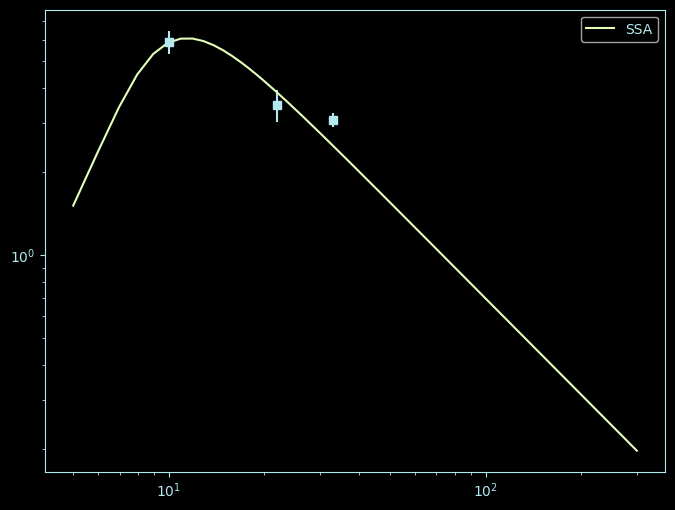

In [303]:
K1_late = 8.53
K2_late = 1.16
make_plot(Aconfig_data, 'sed', freq_vals=np.linspace(5, 300, 300), models=[F_SSA], params=[[K1_late, K2_late, p]], model_names = ['SSA'], cbar=False, modelcolors=[lime])

Determine the peak Flux density from this fit, and the frequency at which it occurs:

In [305]:
# define parameters to load into F_SSA
K1_late = 8.53
K2_late = 1.16

# define arrays of x and y values:
freq_vals=np.linspace(5, 300, 300)
F_late = F_SSA(freq_vals, K1_late, K2_late, p)

# concatenate the two arrays into an astropy table:
table = np.column_stack((freq_vals, F_late))
determine_max_late = Table(table, names=['freq', 'flux'])

# write the loop to determine the max
max_late = determine_max_late['flux'][0]
max_freq_late = determine_max_late['freq'][0]

for i in range(len(determine_max_late)):
    if determine_max_late['flux'][i] > max_late:
        max_late = determine_max_late['flux'][i]
        max_freq_late = determine_max_late['freq'][i]

print(max_late)
print(max_freq_late)

6.049202926431903
11.906354515050168


Now overplot both epochs on one plot:

In [306]:
data_bothepochs = all_data[(all_data['time'] > 1360.0) & (all_data['observation'] != 'CD')]
data_bothepochs

observation,time,freq,flux,flux_err,telescope
str32,float64,float64,float64,float64,str32
KuD,1363.2,15.1,6.476,0.818,VLA
XD,1365.1,10.0,7.023,0.944,VLA
KD,1369.2,22.0,7.055,0.673,VLA
KaD,1369.1,33.0,2.7,0.2,VLA
KA,1688.1,22.0,3.485,0.468,VLA
XA,1689.9,10.0,5.882,0.577,VLA
KaA,1702.2,33.0,3.072,0.177,VLA
0.0,1364.4,100.0,0.955,0.093,ALMA
0.0,1364.4,250.0,0.286,0.067,ALMA


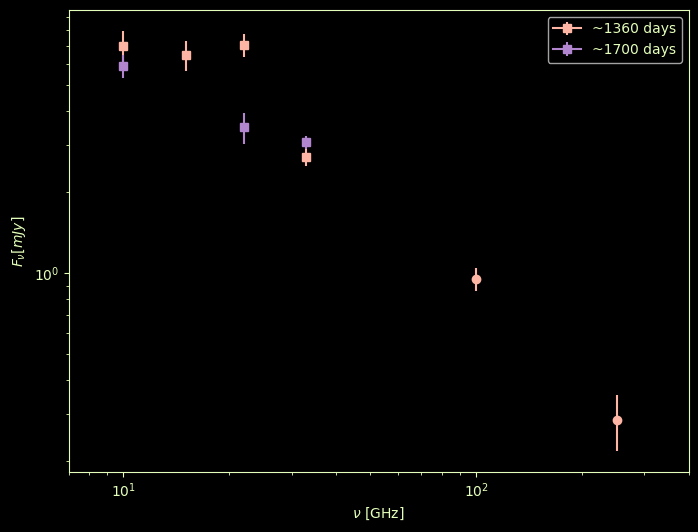

In [353]:
# plot all these data points, without any of the fits, for the presentation:
make_plot(data_bothepochs, 'sed', cbar=False, xlim=(7,400), xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu} [mJy]$')

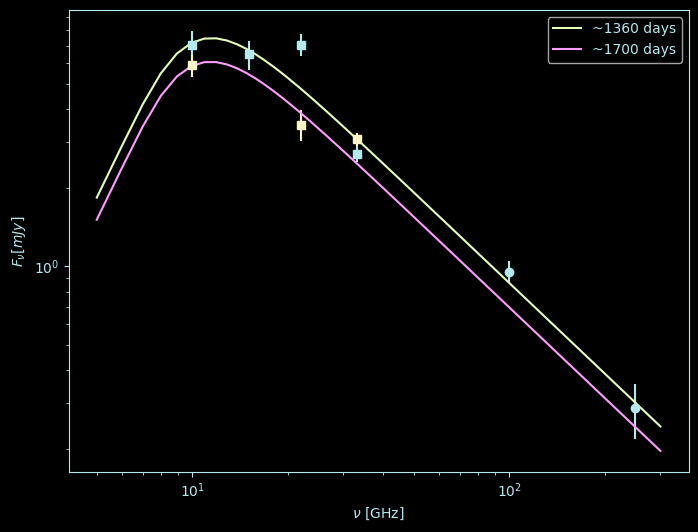

In [373]:
make_plot(data_bothepochs, 'sed', xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu} [mJy]$', freq_vals=np.linspace(5, 300, 300), models=[F_SSA, F_SSA], params=[[K1, K2, p], [K1_late, K2_late, p]], model_names = ['~1360 days', '~1700 days'], cbar=False, modelcolors=[lime, strawberry])

## We can also plot the SSA and FFA fits for each epoch on the same plot, to be able to compare:

Load in the data for ~1360 day epoch:

In [311]:
# take the values from this notebook for the SSA params
SSA_epoch1_fit = [K1, K2, p]

# load in the params from the FFA notebook
K1_FFA = 13.71
K2_FFA = 0.65
alpha = 1.20
FFA_epoch1_fit = [K1_FFA, K2_FFA, alpha]

In [312]:
# define the FFA Flux Density Relation:
def F_FFA(freq, K1, K2, alpha):
    """
    Calculate the flux density using Synchotron Self Absorption (SSA) model.

    Parameters:
    freq (float or numpy.ndarray): Frequency values.
    K1 (float): Scaling factor.
    K2 (float): Scaling factor for the optical depth.
    alpha (float): Power-law index.

    Returns:
    F (numpy.ndarray): Flux density values.
    """
    #scale the freqs by 10
    tau = K2 * (freq/10.0)**(-2.1)
    F = K1 * (freq/10.0)**(-alpha) * (np.exp(-tau))
    return F

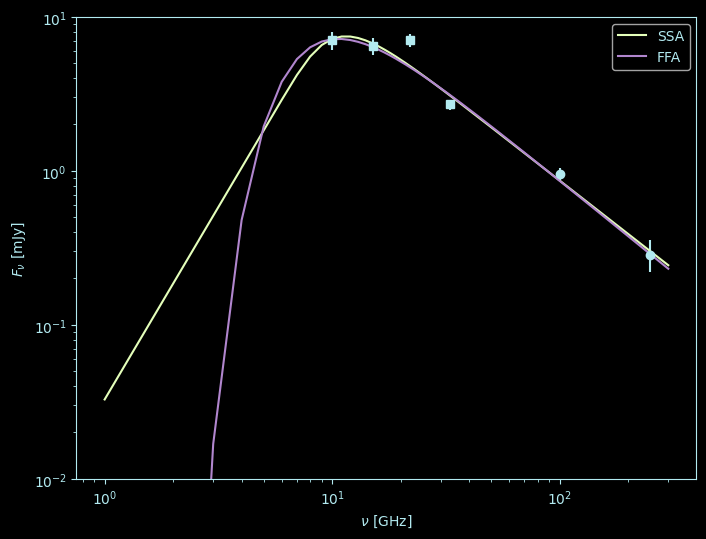

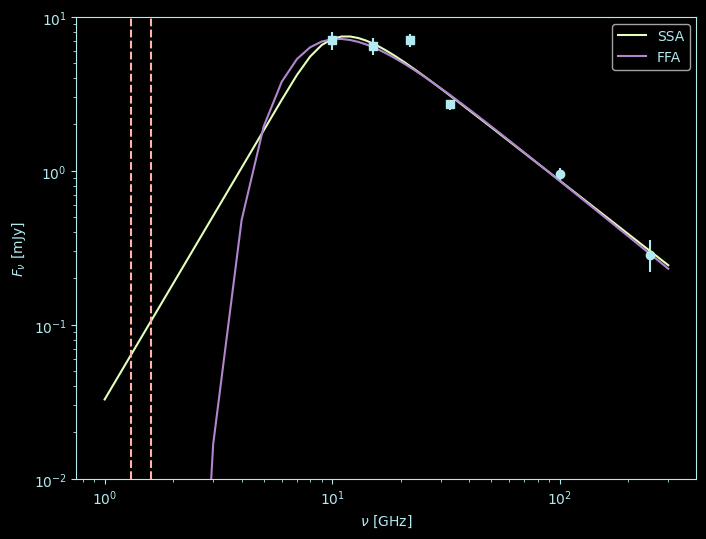

In [376]:
make_plot(data_1, 'sed', xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu}$ [mJy]', freq_vals=np.linspace(1, 300, 300), models=[F_SSA, F_FFA], params=[SSA_epoch1_fit, FFA_epoch1_fit], model_names = ['SSA', 'FFA'], cbar=False, modelcolors=[lime, bora], ylim=(10**-2, 10**1))
make_plot(data_1, 'sed', xlabel=r'$\nu$ [GHz]', ylabel=r'$F_{\nu}$ [mJy]', freq_vals=np.linspace(1, 300, 300), models=[F_SSA, F_FFA], params=[SSA_epoch1_fit, FFA_epoch1_fit], model_names = ['SSA', 'FFA'], cbar=False, modelcolors=[lime, bora], vline=[1.3, 1.6], vlinecolors=[coral, coral], ylim=(10**-2, 10**1))